<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/(transform_GaussianBlur)Strong_STL_10__DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision import utils
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import time
import os


In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [ ]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [ ]:
def Get_psnr(input, output, max_val=255):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().clone().detach().numpy()
    output = output.cpu().clone().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [ ]:
batch_size = 16
torch.manual_seed(1)
torch.cuda.manual_seed(1)


In [ ]:
w_transform = transforms.Compose([
                    transforms.PILToTensor(),                    
                    transforms.GaussianBlur(kernel_size=(3,3),sigma=(0.1,0.1)),
])

In [ ]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 80,000, 10,000, 8,000
org_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = transforms.PILToTensor(), download=True)
hat_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = w_transform, download=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
tr_subset, val_subset = torch.utils.data.random_split(org_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
hat_tr_subset, hat_val_subset = torch.utils.data.random_split(hat_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))



In [ ]:
test_set = datasets.STL10(root = "./data", split = "test",transform = transforms.PILToTensor(), download=True)
hat_test_set = datasets.STL10(root = "./data", split = "test",transform = w_transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)
hat_tr_dataloader = DataLoader(hat_tr_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)

val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)
hat_val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)

test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 4, pin_memory=True)
hat_test_dataloader = DataLoader(hat_test_set, batch_size = batch_size, num_workers = 4, pin_memory=True)

In [ ]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


In [ ]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
    #48 by 48 by 32
        nn.ReLU(True),


        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 

        nn.ReLU(True),

        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
    # 6 by 6 by 256
        nn.ReLU(True),
    )
    self.decoder = nn.Sequential(
 
        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 12 by 12 by 128  
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 24 by 24 by 64

        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),        
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


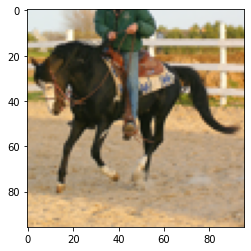

In [ ]:
it = iter(hat_test_dataloader)
a, b = next(it)

plt.imshow(a[0].numpy().transpose(1,2,0))



In [ ]:
a[0]

tensor([[[227, 227, 226,  ..., 229, 228, 229],
         [227, 226, 228,  ..., 228, 229, 228],
         [227, 227, 227,  ..., 228, 229, 229],
         ...,
         [222, 227, 231,  ..., 170, 196, 199],
         [233, 213, 202,  ..., 203, 206, 194],
         [224, 225, 224,  ..., 196, 179, 174]],

        [[235, 235, 236,  ..., 233, 234, 235],
         [235, 235, 235,  ..., 233, 233, 234],
         [235, 236, 236,  ..., 233, 233, 233],
         ...,
         [174, 184, 186,  ..., 147, 163, 167],
         [192, 174, 163,  ..., 168, 167, 158],
         [181, 184, 184,  ..., 153, 146, 138]],

        [[237, 237, 237,  ..., 236, 236, 235],
         [237, 237, 237,  ..., 236, 236, 234],
         [237, 236, 235,  ..., 236, 236, 235],
         ...,
         [115, 119, 120,  ..., 114, 122, 135],
         [133, 121, 109,  ..., 126, 121, 114],
         [131, 130, 134,  ..., 104, 107, 101]]], dtype=torch.uint8)

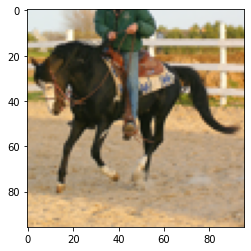

In [ ]:
bt = iter(test_dataloader)
c, d = next(bt)

plt.imshow(c[0].numpy().transpose(1,2,0))

In [ ]:
time.sleep(5.0)

cpu
Epoch : [1/5] 



/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Loss: 15798.461586	 validation Loss 15734.442386
PNSR :43.36 	 SSIM : 0.01
PNSR :8.45 	 SSIM : 0.17
PNSR :0.86 	 SSIM : 0.13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PNSR :3.81 	 SSIM : 0.01
PNSR :-0.83 	 SSIM : 0.01


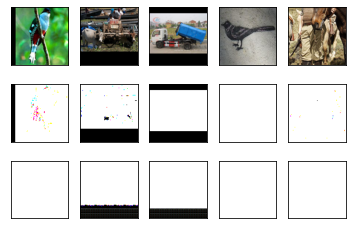

Epoch : [2/5] 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Loss: 15798.248512	 validation Loss 15734.454256
PNSR :43.36 	 SSIM : 0.01
PNSR :8.45 	 SSIM : 0.17
PNSR :0.86 	 SSIM : 0.13
PNSR :3.81 	 SSIM : 0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PNSR :-0.83 	 SSIM : 0.01


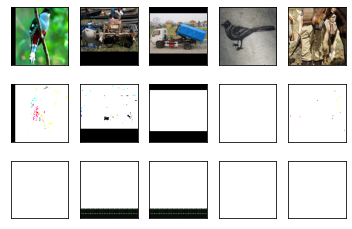

Epoch : [3/5] 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Loss: 15798.246565	 validation Loss 15734.443123
PNSR :43.36 	 SSIM : 0.01
PNSR :8.45 	 SSIM : 0.17
PNSR :0.86 	 SSIM : 0.13
PNSR :3.81 	 SSIM : 0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PNSR :-0.83 	 SSIM : 0.01


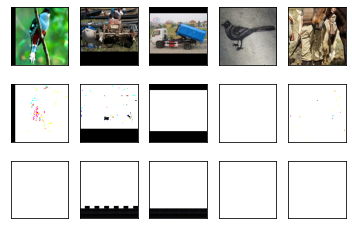

Epoch : [4/5] 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Loss: 15798.237799	 validation Loss 15734.427150
PNSR :43.36 	 SSIM : 0.01
PNSR :8.45 	 SSIM : 0.17
PNSR :0.86 	 SSIM : 0.13
PNSR :3.81 	 SSIM : 0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PNSR :-0.83 	 SSIM : 0.01


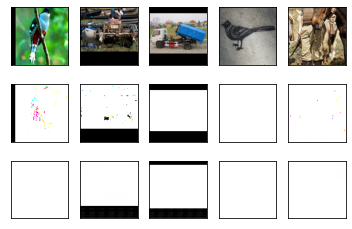

Epoch : [5/5] 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Loss: 15798.228360	 validation Loss 15734.422475
PNSR :43.36 	 SSIM : 0.01
PNSR :8.45 	 SSIM : 0.17
PNSR :0.86 	 SSIM : 0.13
PNSR :3.81 	 SSIM : 0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PNSR :-0.83 	 SSIM : 0.01


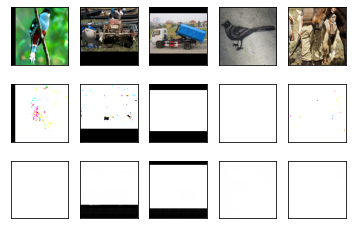

execution time : 78.3min


In [ ]:
#Epochs
n_epochs = 5

device = get_device()
print(device)
model_strong = DenosingAutoencoder()
optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
model_strong=model_strong.to(device)

strong_train_loss_graph = np.array([])
strong_val_loss_graph = np.array([])




start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_strong.eval()
    time.sleep(1.0)
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_loss = 0.0
    total_val_loss = 0.0

    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''
    #Training
    for i,(tr_img, hat_img) in enumerate(zip(tr_dataloader,hat_tr_dataloader)):
        tr_images,_ = tr_img
#        print(tr_images_arr.shape)
        hat_tr_images,_ = hat_img
#check   print(type(hat_tr_images))
        hat_tr_images = hat_tr_images.float().to(device) #데이터 형식이 Byte이기 때문에 신경망 성분인 float으로 변환해야 한다.
#check   print(tr_images.shape)
        tr_outputs =model_strong(hat_tr_images)
        optimizer_strong.zero_grad()
#check0. print(hat_tr_images.shape)  
#check   print(tr_outputs.shape)
        tr_images = tr_images.float().to(device)
        loss = mse_loss(tr_outputs, tr_images).to(device) #여기에 쿠다를 부착하니 성능 급 상승함.
        loss.backward()
        optimizer_strong.step()
        train_loss = loss.clone().detach().item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_dataloader)
    strong_train_loss_graph = np.append(strong_train_loss_graph, total_train_loss)

    
    #evaluation
    model_strong.eval()
    time.sleep(1.0)
    with torch.no_grad():   
        optimizer_strong.zero_grad()
        
        for i, (img, hat_img) in enumerate(zip(val_dataloader, hat_val_dataloader)):
                val_img, _ = img
                hat_val_img,_ = hat_img
                 
                hat_val_img = hat_val_img.float().to(device)
                val_outputs =model_strong(hat_val_img)
#                print('val_outputs shape:',val_outputs.shape )
                val_img = val_img.float().to(device)
                val_loss = mse_loss(val_outputs, val_img)
                val_loss = val_loss.detach().item()
                total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_dataloader)
        strong_val_loss_graph = np.append(strong_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
        if (epoch)%1 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(val_img[j], val_outputs[j])
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(val_outputs[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()

total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

train모드를 eval로 잠깐 만들었음. 훈련 시간 너무 오래 걸려서 그랬다. 다시 돌려놔야 한다.


In [ ]:
plt.imshow(hat_val_img[0].cpu().numpy().transpose(1,2,0))

In [ ]:
hat_val_img[0].cpu().numpy().transpose(1,2,0)

In [ ]:
plt.imshow(val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0))


In [ ]:
 hat_val_img,_ = hat_img
 hat_val_img[0]

In [ ]:
hat_val_img[0]

In [ ]:
val_img[0].cpu().numpy()

In [ ]:
val_ssim = ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)


In [ ]:
val_ssim

In [ ]:
 aa = val_outputs[0].cpu().numpy().astype('double').transpose(1, 2, 0)
 aa

In [ ]:
val_ssim

In [ ]:
val_img[j].cpu().numpy()

In [ ]:
t_val_ssim = ssim(val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0), val_outputs[0].cpu().numpy().astype('uint8').transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
t_val_ssim

In [ ]:
plt.imshow(val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0))

In [ ]:
plt.imshow(hat_val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0))

In [ ]:
val_img[0].shape

In [ ]:
val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0)

In [ ]:
plt.imshow(hat_val_img[j].cpu().numpy().astype(uint8).transpose(1, 2, 0))

In [ ]:
plt.imshow(hat_val_img[j].cpu().numpy().transpose(1, 2, 0)

In [ ]:
PATH1 = '/content/drive/MyDrive/model/model_strong.pth'
torch.save(model_strong.state_dict(), PATH1)

In [ ]:
a = torch.randn(4)
a


In [ ]:
torch.clamp(a, min=0, max=1)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(strong_train_loss_graph,'r-*')
plt.plot(strong_val_loss_graph, 'b-*')
plt.legend(['strong_train_loss','strong_val_loss'])
plt.title("Stl_10")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig('./strong_loss_graph.png')


# strong test

In [ ]:

Gs_blur_strong_test_dataset = []

for j in range(8000):
  hat_img_test_set_arr = cv2.GaussianBlur(img_test_set_arr[j], (41,41),0)
  hat_img_test_set_tensor_byte = torch.from_numpy(hat_img_test_set_arr)
  hat_img_test_set_tensor_float = hat_img_test_set_tensor_byte.float()
  hat_img_test_set_tensor_normal = hat_img_test_set_tensor_float.div(255.0)
  Gs_blur_strong_test_dataset.append([hat_img_test_set_tensor_normal,0])

Gs_blur_strong_test_dataloader = DataLoader(Gs_blur_strong_test_dataset, batch_size = batch_size, num_workers = 4)

# strong graph

# test graph for (average psnr, ssim)

In [ ]:
from skimage.metrics import structural_similarity as ssim

sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_strong.eval()
with torch.no_grad():
    optimizer_strong.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_strong_test_dataloader)):
        
        strong_test_img, _ = test_img
        strong_test_img = strong_test_img.to(device)
        strong_test_hat_img, _ = hat_test_img
        strong_test_hat_img = strong_test_hat_img.to(device)

        test_outputs = model_strong(strong_test_hat_img)
        
    for j in range(10):
        img1_cpu = strong_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        strong_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        strong_psnr = Get_psnr(strong_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=strong_psnr
        sum_ssim+=strong_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(strong_psnr,strong_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(strong_test_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(strong_test_hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(test_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))


In [ ]:
data = iter(Gs_blur_strong_val_dataloader)
img,_ = next(data)
img_uint8 = img[0].numpy().astype('uint8')

plt.imshow(img_uint8.transpose(1,2,0))
img[0]

In [ ]:
print(img[0].shape)